In [4]:
! git clone https://github.com/bavllymagid/Food-Object-Detection-Pytorch-FasterRCNN.git

Cloning into 'Food-Object-Detection-Pytorch-FasterRCNN'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 108 (delta 45), reused 60 (delta 17), pack-reused 0
Receiving objects: 100% (108/108), 2.51 MiB | 11.56 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [1]:
%cd /kaggle/working/Food-Object-Detection-Pytorch-FasterRCNN

/kaggle/working/Food-Object-Detection-Pytorch-FasterRCNN


In [2]:
!pip install pycocotools

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp37-cp37m-linux_x86_64.whl size=373771 sha256=ab2ebeccbed5a33db15001fd83ff558285fb1f4bf6b665384c6a751577e00eb4
  Stored in directory: /root/.cache/pip/wheels/d0/90/d4/e9ae0a3cdbd8e0cddf6b5fe8c31774fb9bd0ae4e9754fb2314
Successfully built pycocotools


In [20]:
# %load /kaggle/working/Food-Object-Detection-Pytorch-FasterRCNN/mainObjDet.py
# Sample code from the TorchVision 0.3 Object Detection Finetuning Tutorial
# http://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
# Modified to fit the problem of Food Classification and Object Detection
# for the UECFOOD100 Dataset

# !!! Numpy 1.17 must be installed !!!

# %%

# Installed Libraries
import os, torch, torchvision
import numpy as np
from PIL import Image
import pandas as pd
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Imported Files
from engine import train_one_epoch, evaluate
import utils
import transforms as T
from prepDataset import load_categories, merge_info, convert_dataset

# %%


class foodDataset(object):
    def __init__(self, root, transforms, bbox_info):
        self.root = root
        self.transforms = transforms
        self.bbox_info = bbox_info

        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(root)))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, self.imgs[idx])

        img = Image.open(img_path).convert("RGB")

        # Find bbox coordinates in bbox_info dataframe
        obj_ids = self.bbox_info.loc[(
            self.bbox_info['img'] == int(self.imgs[idx][:-4]))]

        # get bounding box coordinates for each image
        num_objs = len(obj_ids)
        boxes = []
        for _, bbox in obj_ids.iterrows():
            boxes.append([bbox.x1, bbox.y1, bbox.x2, bbox.y2])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # each image might belong to several classes
        labels = torch.as_tensor(obj_ids.category.tolist(), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

# %%

def get_model_object_detection(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
        pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# %%

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# %%

def main():

    root = "../UECFOOD100merged"
    img_dir = "Images"

    # Uncomment the following lines to convert dataset's
    # folder structure to the appropriate one. 
    
    """
    old_root = "/kaggle/input/uecfood100/UECFOOD100"
    # Copy all images and categories.txt file the a new dir
    convert_dataset(old_root, root)
    # Collect all the bbox information in a dataframe
    bbox_info = merge_info(old_root)
    # Save the dataframe as a .csv file
    bbox_info.to_csv(os.path.join(root,'bbox.csv'), index = False)
    """
    # All images should be located at the same directory 
    # (ie. UECFOOD100merged) without any subdirs. The file 
    # which contains the labels of the various classes, named 
    # categories.txt, should be coppied to the new root dir 
    # and a csv file which contains the bbox information should 
    # also be imported.

    bbox_info = pd.read_csv(os.path.join(root,'bbox.csv'))
    categ_labels = load_categories(root)
    
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device(
        'cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = len(categ_labels) + 1
    
    img_path = os.path.join(root, img_dir)

    # use our dataset and defined transformations
    dataset = foodDataset(img_path, get_transform(train=True), bbox_info)
    dataset_test = foodDataset(img_path, get_transform(train=False), bbox_info)

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    if(os.path.exists("/kaggle/working/model.pth")):
        model = torch.load("../model.pth")
    else:
        model = 1

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=3, gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(
            model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # save model
        torch.save(model, os.path.join('../', 'model2.pth'))
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)


if __name__ == "__main__":
    main()

Epoch: [9]  [ 5010/12690]  eta: 0:20:13  lr: 0.000005  loss: 0.1024 (0.1353)  loss_classifier: 0.0473 (0.0754)  loss_box_reg: 0.0174 (0.0422)  loss_objectness: 0.0003 (0.0022)  loss_rpn_box_reg: 0.0123 (0.0155)  time: 0.1590  data: 0.0060  max mem: 1830
Epoch: [9]  [ 5020/12690]  eta: 0:20:12  lr: 0.000005  loss: 0.1138 (0.1352)  loss_classifier: 0.0501 (0.0754)  loss_box_reg: 0.0186 (0.0421)  loss_objectness: 0.0004 (0.0022)  loss_rpn_box_reg: 0.0123 (0.0155)  time: 0.1624  data: 0.0063  max mem: 1830
Epoch: [9]  [ 5030/12690]  eta: 0:20:10  lr: 0.000005  loss: 0.0998 (0.1353)  loss_classifier: 0.0501 (0.0754)  loss_box_reg: 0.0338 (0.0422)  loss_objectness: 0.0008 (0.0022)  loss_rpn_box_reg: 0.0093 (0.0155)  time: 0.1588  data: 0.0061  max mem: 1830
Epoch: [9]  [ 5040/12690]  eta: 0:20:08  lr: 0.000005  loss: 0.0895 (0.1353)  loss_classifier: 0.0449 (0.0754)  loss_box_reg: 0.0300 (0.0422)  loss_objectness: 0.0004 (0.0022)  loss_rpn_box_reg: 0.0089 (0.0155)  time: 0.1578  data: 0.0056

[17 98 98 98 17 98 96 16]
[17 98]
pred: hamburger | Accuracy: 99.72 %
pred: french fries | Accuracy: 99.28 %


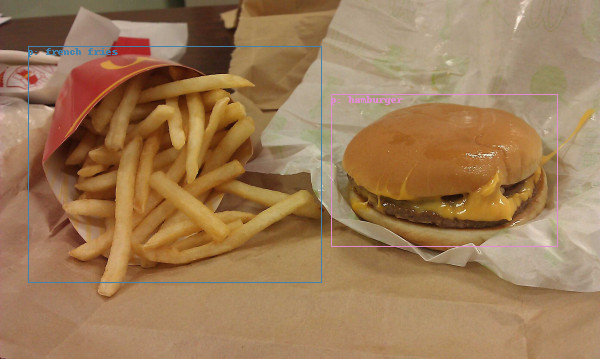

In [25]:
# Manually Check Model's Results

from PIL import ImageDraw, Image
import numpy as np
import os
from prepDataset import merge_info
from torchvision import transforms
import os, torch, torchvision
import numpy as np
from PIL import Image
import pandas as pd
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Imported Files
from engine import train_one_epoch, evaluate
import utils
import transforms as T
from prepDataset import load_categories, merge_info, convert_dataset


root = '../UECFOOD100merged'
img_dir = 'Images'
img_path = os.path.join(root, img_dir)

model = torch.load("../model2.pth")

labels = load_categories(root)
bbox_info = pd.read_csv(os.path.join(root,'bbox.csv'))


dataset = foodDataset(img_path, get_transform(train=True),bbox_info)
dataset_test = foodDataset(img_path, get_transform(train=False), bbox_info)

indices = torch.randperm(len(dataset)).tolist()

dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)


# %%
from PIL import ImageDraw
from torchvision import transforms
import random

N = 7

device = 'cuda' if torch.cuda.is_available() else 'cpu'
imag, target = dataset_test[N]

model.eval()
with torch.no_grad():
    prediction = model([imag.to(device)])


img = transforms.ToPILImage(mode='RGB')(imag)

draw = ImageDraw.Draw(img)

b = prediction[0]['boxes'].cpu().numpy()
l = prediction[0]['labels'].cpu().numpy()
print(l)
s = prediction[0]['scores'].cpu().numpy()

b_real = target['boxes'].cpu().numpy()
l_real = target['labels'].cpu().numpy()
print(l_real)

for i in range(len(b)):

    color = tuple([random.randint(0,255) for _ in range(4)])
    
    if s[i] > 0.3 :
        box_loc = list(b[i])
        draw.rectangle(xy=box_loc, outline = color[0:3])
        draw.text((box_loc[0],box_loc[1]), 'p: '+labels[l[i]],  fill=color)
        print(f'pred: {labels[l[i]]} | Accuracy: {100*s[i]:.2f} %')
"""
for i in range(len(b_real)):

    color_real = tuple(map(lambda x: x+50, color))
    box_real = list(b_real[i])
    draw.rectangle(xy=box_real, outline= color_real[0:3])
    draw.text((box_real[0],box_real[1]),'r: '+labels[l_real[i]], fill=color_real)
    print(f'real: {labels[l_real[i]]}')
"""
img